## Diabetes Diagnosis

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import expectation_reflection as ER
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

The data contains 8 features:<br/>
1) Pregnancies: Number of times pregnant<br/>
2) Glucose: Plasma glucose concentration at 2 hours in an oral glucose tolerance test (GTT)<br/>
3) BloodPressure: Diastolic blood pressure (mmHg)<br/>
4) SkinThickness: Triceps skin fold thickness (mm)<br/>
5) Insulin: 2-Hour serum insulin (mu U/ml)<br/>
6) BMI: Body Mass Index (weight(kg)/(height(m))^2)<br/>
7) DiabetesPedigreeFunction: Diabetes Pedigree Function<br/>
8) Age: Age (years)<br/>

and 1 target: 1 (positive), 0 (negative)

### Impute missing data

In [3]:
# impute missing data
Xy = np.loadtxt('../diabetes_data_imputed_knn3.txt').astype(float)

# select features and target:
X = Xy[:,:8]
y = Xy[:,8]

# convert 1,0 to 1,-1:
y = 2*y - 1

In [4]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

### Prediction

In [5]:
def inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=100,regu=0.01)
        y_pred = ER.predict(X_test,h0,w)

    else:
        if method == 'logistic_regression':
            model = LogisticRegression(solver='liblinear')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)   
            
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    accuracy = accuracy_score(y_test,y_pred)                
                  
    return accuracy

In [6]:
def compare_inference(X,y,train_size):
    npred = 100
    accuracy = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        #X, y = shuffle(X, y)
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)
        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = inference(X_train,y_train,X_test,y_test,method)
            
    return accuracy.mean(axis=1),accuracy.std(axis=1)

In [7]:
list_train_size = [0.8,0.6,0.4,0.2]
list_methods=['logistic_regression','naive_bayes','random_forest','expectation_reflection']
acc = np.zeros((len(list_train_size),len(list_methods)))
acc_std = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:],acc_std[i,:] = compare_inference(X,y,train_size)
    print(train_size,acc[i,:])

0.8 [0.76344156 0.74493506 0.75396104 0.76707792]
0.6 [0.76175325 0.7461039  0.75519481 0.76409091]
0.4 [0.75545455 0.74603896 0.75337662 0.76058442]
0.2 [0.74558442 0.74090909 0.74909091 0.75915584]


In [8]:
acc_std

array([[0.03068146, 0.03085721, 0.03314736, 0.02929507],
       [0.02972431, 0.03144494, 0.03284842, 0.03009591],
       [0.03065348, 0.03092293, 0.03049847, 0.03065946],
       [0.03600683, 0.03251296, 0.03171225, 0.03293296]])

In [9]:
df = pd.DataFrame(acc,columns = list_methods)
df.insert(0, "train_size",list_train_size, True)
df

,train_size,logistic_regression,naive_bayes,random_forest,expectation_reflection
0,0.8,0.763442,0.744935,0.753961,0.767078
1,0.6,0.761753,0.746104,0.755195,0.764091
2,0.4,0.755455,0.746039,0.753377,0.760584
3,0.2,0.745584,0.740909,0.749091,0.759156


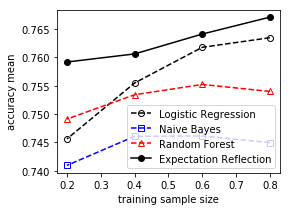

In [10]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc[:,-1],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('training sample size')
plt.ylabel('accuracy mean')
plt.legend()

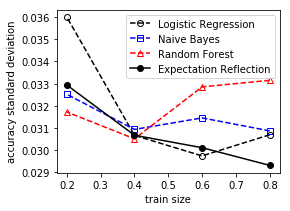

In [12]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc_std[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc_std[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc_std[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc_std[:,-1],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy standard deviation')
plt.legend()

In [14]:
np.savetxt('diabetes_acc.txt',acc,fmt='%f')
np.savetxt('diabetes_acc_std.txt',acc_std,fmt='%f')